In [1]:
from itertools import product
import multiprocessing

import pandas as pd
import seaborn as sns
import matplotlib as plt
import scipy.sparse as sp
import numpy as np

from fairpair import *

In [2]:
from accuracy_workers import *

## Export Graphs

In [4]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [8]:
sampler = RandomSampling(G, warn=False)
ranker = RankRecovery(G)
path = './data/GNNRank_networks/'

for j in range(101):
    sampler.apply(iter=10, k=1)
    if nx.is_strongly_connected(G): # only apply ranking recovery if strongly connected
        adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
        nodes = np.array(G.nodes)
        sp.save_npz(f'{path}random_iter{j*10}_adj', adj)
        np.save(f'{path}random_iter{j*10}_node_list', nodes)

## Read Results

In [3]:
path = './data/GNNRank_results/'
ranking = np.load(f'{path}DIGRACinnerproduct_pred0.npy')

In [ ]:
ranks = []
j = 500
for node, data in G.majority.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Privileged'))
for node, data in G.minority.nodes(data=True):
    ranks.append((j, data['skill'], data['bias'], data['score'], ranking[node], 'Unprivileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])

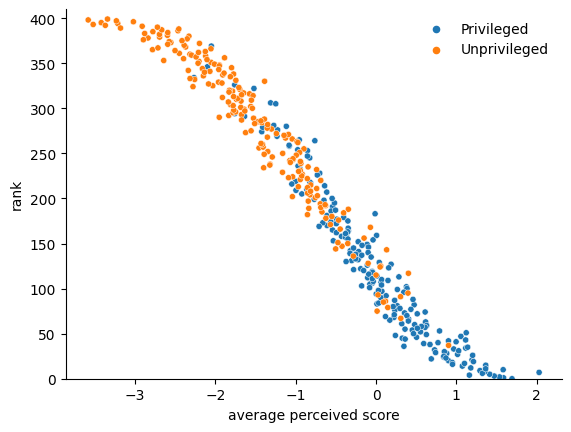

In [14]:
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()

## Integrated Evaluation

In [3]:
import torch

import sys
sys.path.append('../GNNRank/') # also add the path to Pylance in VSCode settings: python.analysis.extraPaths

from src.param_parser import ArgsNamespace # just import the class, not the parser
from src.Trainer import Trainer

In [4]:
# Instead of parsing, set all arguments directly
# Carefully check if the settings are actually possible!
args = ArgsNamespace(AllTrain=True, ERO_style='uniform', F=70, Fiedler_layer_num=5, K=20, N=350, SavePred=False, all_methods=['DIGRAC', 'ib'],
                     alpha=1.0, baseline='syncRank', cuda=True, data_path='/home/jovyan/GNNRank/src/../data/', dataset='fairPair_test/',
                     debug=False, device=torch.device(type='cuda'), dropout=0.5, early_stopping=200, epochs=1000, eta=0.1, fill_val=0.5, hidden=8, hop=2,
                     load_only=False, log_root='/home/jovyan/GNNRank/src/../logs/', lr=0.01, no_cuda=False, num_trials=1, optimizer='Adam', p=0.05,
                     pretrain_epochs=50, pretrain_with='dist', regenerate_data=True, season=1990, seed=31, seeds=[10], sigma=1.0, tau=0.5, test_ratio=1,
                     train_ratio=1, train_with='proximal_baseline', trainable_alpha=False, upset_margin=0.01, upset_margin_coeff=0, upset_ratio_coeff=1.0, weight_decay=0.0005)
torch.manual_seed(args.seed)

In [46]:
G = FairPairGraph()
G.generate_groups(400, 200) # same size groups
G.assign_skills(loc=0, scale=0.86142674) # general skill distribution
G.assign_bias(nodes=G.minority_nodes, loc=-1.43574282, scale=0.43071336) # add bias to unprivileged group

In [47]:
sampler = RandomSampling(G, warn=False)
sampler.apply(iter=40, k=1)
print('G is strongly connected.' if nx.is_strongly_connected(G) else 'G is NOT strongly connected!')
print(f'G has {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

G is NOT strongly connected!
G has 400 nodes and 3166 edges.


In [84]:
adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
trainer = Trainer(args, random_seed=10, save_name_base='test', adj=adj) # initialize with the given adjacency matrix

Generating new data or new data splits!
loaded test_mask: None


In [8]:
save_path_best, save_path_latest = trainer.train(model_name='ib')

  0%|          | 0/1000 [00:00<?, ?epochs/s]

Early stopped after 200 epochs without improvement.


In [ ]:
### Test modifying the network to investigate effects on generalizability

## Adding comparisons
#sampler.apply(iter=1000, k=1)
#print(f'G has {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

## Dropping edges
#rng = np.random.default_rng()
#to_remove = rng.choice(G.edges, size=1000, replace=False)
#G.remove_edges_from(to_remove)
#print(f'Removed 40000 edges. G has now {G.number_of_nodes()} nodes and {len(G.edges)} edges.')

In [94]:
#adj = nx.linalg.graphmatrix.adjacency_matrix(G, weight='weight') # returns a sparse matrix
# We load A while initializing a new Trainer instance
score, pred_label = trainer.predict_nn(model_name='ib', model_path=save_path_best, A=None, GNN_variant='proximal_baseline')
ranking = {key: 1-score for key, score in enumerate(score.cpu().detach().numpy())}

In [95]:
weighted_tau(G, ranking, score_attr='score')

0.031109216081659015

In [96]:
ranker = RankRecovery(G)
ranking2, other_nodes = ranker.apply()
weighted_tau(G, ranking2, score_attr='score')

0.03449006146058768

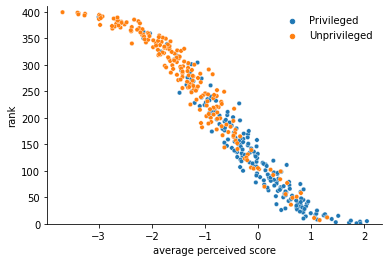

In [97]:
ranks = []
j = 500

for node, data in G.nodes(data=True):
    ranks.append((j, data['skill'], 0, data['score'], ranking[node], 'Unprivileged' if data['minority'] else 'Privileged'))
ranks = pd.DataFrame(ranks, columns=['iteration', 'skill score', 'bias', 'average perceived score', 'rank', 'group'])
data = ranks
data['rank'] = [rank for rank in scores_to_rank({node:score for node, score in enumerate(list(data['rank']))}, invert=True).values()]
ax = sns.scatterplot(data, x='average perceived score', y='rank', hue='group', hue_order=['Privileged', 'Unprivileged'], size='group', sizes=(20,20))
ax.legend(title=None, frameon=False, loc='upper right')
ax.set(ylim=(0,410)) # xlim=(-10, 10)
sns.despine()

## Parallel GNNRank

In [ ]:
if __name__ == '__main__':
    multiprocessing.set_start_method('spawn')
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.map(get_GNNRank_accuracy, range(10))
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'group'])

In [4]:
accuracy.to_csv('./data/GNNRank_results/skill_accuracy_no_bias.csv', index=False)

In [3]:
accuracy = pd.read_csv('./data/GNNRank_results/skill_accuracy.csv')

In [4]:
tasks = list(product(range(10), [davidScore, rankCentrality]))

if __name__ == '__main__':
    pool = multiprocessing.Pool()
    accuracy2 = pool.starmap(get_method_accuracy, tasks)
    accuracy2 = [result for pool in accuracy2 for result in pool]
    accuracy2 = pd.DataFrame(accuracy2, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'group', 'method'])

In [5]:
accuracy['method'] = 'GNNRank'
data = pd.concat([accuracy, accuracy2])

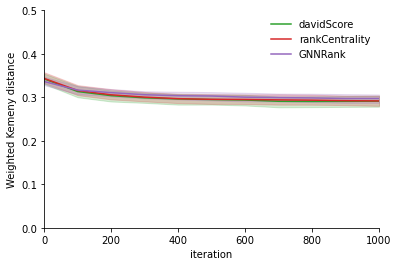

In [6]:
palette = sns.color_palette()
palette[0] = palette[2]
palette[1] = palette[3]
palette[2] = palette[4]
with sns.color_palette(palette):
    ax = sns.lineplot(data, x='iteration', y='Weighted Kemeny distance', hue='method', hue_order=['davidScore', 'rankCentrality', 'GNNRank'])
ax.legend(title=None, frameon=False, prop={'size': 10})
ax.set(ylim=(0,0.5), xlim=(0,1000))
sns.despine()
ax.figure.savefig('accuracy_y5.png',dpi=600)

## Generalizability

In [3]:
tasks = list(product(range(10), [100]))

if __name__ == '__main__':
    try: multiprocessing.set_start_method('spawn') # if it wasn't alrady set, make sure we use the `spawn` method.
    except RuntimeError: pass
    pool = multiprocessing.Pool(processes=10) # limit the num of processes in order to not overflow the GPU memory
    accuracy = pool.starmap(get_GNNRank_generalizability, tasks)
    accuracy = [result for pool in accuracy for result in pool]
    accuracy = pd.DataFrame(accuracy, columns=['trial', 'iteration', 'Weighted Kemeny distance', 'Model trained after'])

 20%|█▉        | 195/1000 [00:53<04:06,  3.27epochs/s, train loss: 0.961, val loss: 0.961]

trial 4, train_after 100: finished 0 iterations.


 20%|██        | 201/1000 [00:55<03:46,  3.53epochs/s, train loss: 0.963, val loss: 0.963]

trial 0, train_after 100: finished 0 iterations.


 20%|██        | 205/1000 [00:55<03:05,  4.27epochs/s, train loss: 0.963, val loss: 0.963]

trial 9, train_after 100: finished 0 iterations.


 21%|██▏       | 214/1000 [00:57<02:26,  5.35epochs/s, train loss: 0.963, val loss: 0.963]

trial 7, train_after 100: finished 0 iterations.


 22%|██▏       | 224/1000 [01:00<02:45,  4.70epochs/s, train loss: 0.964, val loss: 0.964]

trial 6, train_after 100: finished 0 iterations.


 22%|██▎       | 225/1000 [01:00<02:48,  4.60epochs/s, train loss: 0.963, val loss: 0.963]

trial 8, train_after 100: finished 0 iterations.


 24%|██▍       | 244/1000 [01:03<02:19,  5.41epochs/s, train loss: 0.964, val loss: 0.964]

trial 3, train_after 100: finished 0 iterations.


 25%|██▌       | 250/1000 [01:04<03:13,  3.88epochs/s, train loss: 0.964, val loss: 0.964]


trial 1, train_after 100: finished 0 iterations.
trial 2, train_after 100: finished 0 iterations.


 29%|██▊       | 286/1000 [01:08<02:51,  4.16epochs/s, train loss: 0.963, val loss: 0.963]


trial 5, train_after 100: finished 0 iterations.
trial 4, train_after 100: finished 100 iterations.
trial 0, train_after 100: finished 100 iterations.
trial 9, train_after 100: finished 100 iterations.
trial 7, train_after 100: finished 100 iterations.
trial 6, train_after 100: finished 100 iterations.
trial 8, train_after 100: finished 100 iterations.
trial 1, train_after 100: finished 100 iterations.
trial 3, train_after 100: finished 100 iterations.
trial 2, train_after 100: finished 100 iterations.
trial 5, train_after 100: finished 100 iterations.
trial 4, train_after 100: finished 200 iterations.
trial 0, train_after 100: finished 200 iterations.
trial 9, train_after 100: finished 200 iterations.
trial 7, train_after 100: finished 200 iterations.
trial 6, train_after 100: finished 200 iterations.
trial 1, train_after 100: finished 200 iterations.
trial 8, train_after 100: finished 200 iterations.
trial 2, train_after 100: finished 200 iterations.
trial 3, train_after 100: finishe

In [4]:
accuracy.to_csv('./data/GNNRank_results/generalizability100_no_bias.csv', index=False)

In [13]:
accuracy1 = pd.read_csv('./data/GNNRank_results/generalizability_no_bias.csv') # includes data for 50, 500, 1000
accuracy2 = pd.read_csv('./data/GNNRank_results/generalizability100_no_bias.csv') # includes data for 100
accuracy3 = pd.read_csv('./data/GNNRank_results/skill_accuracy_no_bias.csv') # includes data for baseline (trained after each step)
accuracy1['Model trained after'] = accuracy1['Model trained after'].map(str) + ' iterations'
accuracy1.iteration += 10
accuracy2['Model trained after'] = accuracy2['Model trained after'].map(str) + ' iterations'
accuracy2.iteration += 10
accuracy3['Model trained after'] = 'each step'
accuracy3.iteration += 100 # offset is larger because steps are coarser
data = pd.concat([accuracy1, accuracy2, accuracy3])

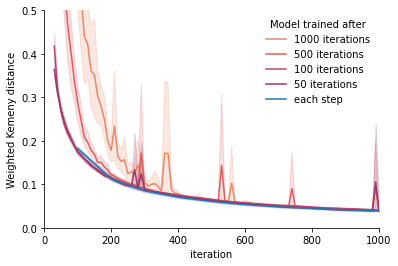

In [18]:
std_palette = sns.color_palette()
palette = sns.color_palette('flare', 5)
palette[4] = std_palette[0]
ax = sns.lineplot(data, x='iteration', y='Weighted Kemeny distance', hue='Model trained after',
                  hue_order=['1000 iterations', '500 iterations', '100 iterations', '50 iterations', 'each step'], palette=palette)
ax.legend(title='Model trained after', frameon=False, prop={'size': 10})
ax.set(ylim=(0,0.5), xlim=(0,1000))
sns.despine()
ax.figure.savefig('generalizability_y5.png',dpi=600)